In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from bayopt.gaussian import MM_BSL
from scipy.io import loadmat
import tensorly as tl

Using numpy backend.


In [2]:
nAntennas = 8
B = 1.023e6
Tc = 1/B
T  = 1e-3
IDsat = 20

In [3]:
A_dict = loadmat('dataset/A.mat')
A = A_dict['A']

In [4]:
G_dict = loadmat('dataset/Gamma.mat')
G = G_dict['Gamma']
t = G_dict['taulos']

In [5]:
Cq_dict = loadmat('dataset/CQw.mat')
CQw = Cq_dict['CQw']

In [6]:
tau_space = np.linspace(-Tc,Tc,22)
B_dict = loadmat('dataset/bank_22.mat')
B = B_dict['CQw'].T

In [7]:
print(B.shape)
print(A.shape)
print(G.shape)
print(CQw.shape)

(11, 22)
(8, 2, 3)
(2, 30, 2000)
(2, 11, 11, 2000)


In [ ]:
M = A.shape[0]
Q = CQw.shape[1]
K = G.shape[1]

In [9]:
# Construct post-correlated tensor signal
def pos_signal_tensor(delta_angle_idx,MC_idx,delta_tau):
    S = G[:,:,MC_idx].T @ tl.tenalg.khatri_rao([CQw[:,:,delta_tau,MC_idx].T, A[:,:,delta_angle_idx]]).T
    return tl.tensor(S.reshape(K,Q,M))


In [10]:
def noise():
    N = 1 / np.sqrt(2) * (np.random.randn(K, Q*M) + 1j * np.random.randn(K, Q*M))
    return tl.tensor(N.reshape(K,Q,M))

In [11]:
def sparse_angle_delay_estimation(Tensor,B, A, a=9.5, b=0.4, c=8, d=9):
    Y_filtered = tl.tenalg.mode_dot(Tensor,np.linalg.pinv(A),mode=2)
    Y = tl.unfold(Y_filtered, mode=1)
    beta, sigma, error = MM_BSL(B, Y, a, b, c, d,100)
    return beta, sigma, error

In [12]:
def sparse_delay_estimation(Tensor,B, a=0, b=0, c=0, d=0):
    Y = tl.unfold(Tensor, mode=1)
    beta, sigma, error = MM_BSL(B, Y, a, b, c, d,100)
    return beta, sigma, error

In [13]:
def rmse(tau_los_true,beta_tau):
    #idx_peaks = find_peaks(np.fft.fftshift(np.sum(np.abs(beta_tau) ** 2, axis=1)))[0]
    #idx_sort = np.flipud(np.argsort(np.fft.fftshift(np.sum(np.abs(beta_tau) ** 2, axis=1))[idx_peaks]))
    #tau_est = np.abs(self.tau_space[idx_peaks[idx_sort]]
    #tau_los_est = np.abs(tau_space[idx_peaks[idx_sort[0]]])
    idx = np.argmax(np.sum(np.abs(beta_tau) ** 2, axis=1))
    tau_los_est = tau_space[idx]
    return 3e8 * np.abs(tau_los_true - tau_los_est),tau_los_est


In [14]:
Y  = pos_signal_tensor(0,0,0) + noise()




In [15]:
from bayes_opt.bayesian_optimization import BayesianOptimization

In [16]:
def calibration_function(a,b,c,d):
    #beta, sigma, error = sparse_angle_delay_estimation(Y,B,A[:,:,0],a,b,c,d)
    beta, sigma, error = sparse_delay_estimation(Y,B,A[:,:,0],a,b,c,d)

    return -error



In [17]:

# Bounded region of parameter space
pbounds = {'a': (0, 15), 'b': (0, 15),'c': (0, 15), 'd': (0, 15)}

optimizer = BayesianOptimization(
    f=calibration_function,
    pbounds=pbounds,
    random_state=1,
)

In [18]:
optimizer.maximize(
    init_points=20,
    n_iter=5,
)

|   iter    |  target   |     a     |     b     |     c     |     d     |
-------------------------------------------------------------------------
|  1        | -1.369e+0 |  6.255    |  10.8     |  0.001716 |  4.535    |
|  2        | -1.476e+0 |  2.201    |  1.385    |  2.794    |  5.183    |
|  3        | -7.529    |  5.952    |  8.082    |  6.288    |  10.28    |
|  4        | -7.723    |  3.067    |  13.17    |  0.4108   |  10.06    |
|  5        | -1.348e+0 |  6.26     |  8.38     |  2.106    |  2.972    |
|  6        | -9.389    |  12.01    |  14.52    |  4.701    |  10.38    |
|  7        | -1.435e+0 |  13.15    |  13.42    |  1.276    |  0.5858   |
|  8        | -6.511    |  2.547    |  13.17    |  1.475    |  6.317    |
|  9        | -10.47    |  14.37    |  7.997    |  10.38    |  4.733    |
|  10       | -1.433e+0 |  10.3     |  12.52    |  0.2743   |  11.25    |
|  11       | -1.422e+0 |  14.83    |  11.22    |  4.207    |  11.84    |
|  12       | -5.18     |  1.548    | 

In [19]:
print(optimizer.max['params'])


{'a': 0.7493018841913074, 'b': 8.038446088732673, 'c': 9.956919678296833, 'd': 7.723336680874628}


In [20]:
print(optimizer.max['target'])

-4.932667176713486


In [21]:
# Tau_los Estimation
#beta, sigma, error = sparse_delay_estimation(Y,B)
beta, sigma, error = sparse_angle_delay_estimation(Y,B,A[:,:,0],optimizer.max['params']['a'],optimizer.max['params']['b'],optimizer.max['params']['c'],optimizer.max['params']['d'])
rmse,tau_est = rmse(t[0,0],beta)

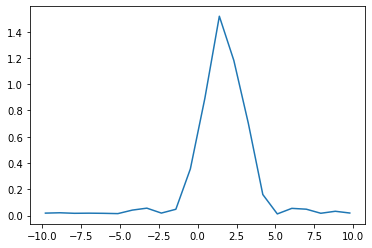

In [22]:
plt.plot(tau_space/1e-7,np.mean(np.abs(beta)**2,axis=1))
plt.show()

In [23]:
print(tau_est)
print(t[0,0])
print(rmse)




1.396453009356234e-07
1.6692770582241164e-07
8.184721466036477
